<a href="https://colab.research.google.com/github/ashalem/ML_Human/blob/main/WS3_2024_students.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div>Machine Learning and Human Behavior - 236667 - Winter 2024-2025</div>
<font size="6">Workshop #3 - Biased inputs, biased outputs 🦡</font>

IDS: 316333368, 3148446602

# Instructions and submission guidelines

* Clone this notebook and complete the exercise:
    * Aim for clear and concise solutions.
    * Indicate clearly with a text block the sections of your solutions.
    * Answer dry questions in text (markdown) blocks, and wet questions in code blocks.
* Submission guidelines:
    * When you're done, restart the notebook, and make sure that everything runs smoothly (Runtime->"Restart and Run All")
    * Add a text block in the beginning of your notebook with your IDs.
    * Export your notebook as ipynb (File->Download->"Download .ipynb")
    * If you need to attach additional files to your submission (e.g images), add them to a zip file together with the notebook ipynb file.
    * Submit through the course website. Remember to list partner IDs when you submit.
* **Due date**: Sunday 5/1/2025, 10:00
* For any questions regarding this workshop task, contact [Lotan](mailto:lotan.amit@campus.technion.ac.il).


## Preliminaries
Run these cells to load into memory interface objects and functions that will be used throughtout today's workshop.

No need to read the actual code.

In [1]:
from typing import Iterable, Set, Tuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import ndcg_score, precision_score, recall_score, mean_squared_error
from scipy.stats import bernoulli, binom, norm
import uuid
from typing import List, Tuple
import seaborn as sns


from tqdm.auto import tqdm

CLICKS_NOISE_SCALE = 5
RATINGS_NOISE_SCALE = 2
LATENT_DIMENSION = 30
np.random.seed(42)

In [2]:
#@title RateClickEnvironment

class RateClickEnvironment(object):
  FEATURE_COLUMNS = [f'x{i+1}' for i in range(8)]

  def __init__(self, thresh_click=2, eps_click=0.4,
               eps_rating=1, user_mu=0, user_sigma=1):
    self.thresh_click = thresh_click
    self.eps_click = eps_click
    self.eps_rating = eps_rating
    self._latent_dim = len(self.FEATURE_COLUMNS)
    self.top_k_idxs = np.arange(self._latent_dim)<5

    self._user_features = np.abs(np.random.normal(user_mu, user_sigma, self._latent_dim))# np.abs(np.random.randn(self._latent_dim))
    self._user_features /= np.linalg.norm(self._user_features)
    self._user_features_topk = self._user_features*self.top_k_idxs

    self.ndcg_10 = lambda y_true, y_est: ndcg_score(
    np.expand_dims(y_true, 0),
    np.expand_dims(y_est, 0),
    k=10,
    )

  def _generate_dataframe(self, n_samples, seed=None) -> pd.DataFrame:
    if seed is not None:
      np.random.seed(seed)
      print('in')
    return pd.DataFrame(
        index=pd.Index(
            data=[str(uuid.uuid4()) for _ in range(n_samples)],
            name='item_id',
        ),
        data={
            feature_name: np.random.randn(n_samples)
            for feature_name in self.FEATURE_COLUMNS
        }
    )

  @staticmethod
  def _click_transform(x):
    return x>2

  @staticmethod
  def _rating_transform(x):
    sigmoid = lambda x: 1/(1+np.exp(-x))
    return np.round((sigmoid(x*1.5)-0.5)*4 + 3).astype(int)

  def generate_evaluation_set(self, n_samples: int, seed: int=None) -> pd.DataFrame:
    df = self._generate_dataframe(n_samples, seed)
    X = df[self.FEATURE_COLUMNS].to_numpy()
    scores = X@self._user_features
    y = self._rating_transform(scores)
    return df.assign(true_relevance=y)

  def generate_training_set(self, n_samples: int, seed: int=None):
    df = self._generate_dataframe(n_samples, seed)
    X = df[self.FEATURE_COLUMNS].to_numpy()
    for _ in range(1000):  # rejection sampling
      noisy_scores = X@self._user_features_topk + self.eps_click*np.random.logistic(size=X.shape[0])
      y_click = pd.array(
          (noisy_scores > self.thresh_click),
          dtype=pd.Int64Dtype()
      )
      if len(y_click.unique())>1 and y_click.value_counts().min()>1:
        break
    for _ in range(1000):  # rejection sampling
      noisy_scores = X@self._user_features + self.eps_rating*np.random.logistic(size=X.shape[0])
      y_rating = pd.array(
          self._rating_transform(noisy_scores),
          dtype=pd.Int64Dtype(),
      )
      y_rating[y_click==0] = None
      if len(y_rating.dropna().unique())>1:
        break

    return df.assign(click=y_click, rating=y_rating)

  def build_X_y_matrices(
    self,
    df: pd.DataFrame,
    label_column: str,
    feature_columns: List[str]=FEATURE_COLUMNS,
    get_valid_entries:bool=False ) -> Tuple[np.ndarray, np.array]:
    valid_entries = pd.notna(df[label_column])
    X = df.loc[valid_entries][feature_columns].to_numpy()
    y = df.loc[valid_entries][label_column].to_numpy()
    if get_valid_entries:
      return X,y,valid_entries
    else:
      return X,y

def generate_population(utype_1='ranting', user_mu_1=-1, user_sigma_1=0.5,
                        thresh_click_1=1, ratio=4, utype_2='extreme',
                        user_mu_2=2, user_sigma_2=2, thresh_click_2=2
                        ):
# utype_1='ranting'
# user_mu_1=-1
# user_sigma_1=0.5
# thresh_click_1=1
# ratio=4
# utype_2='extreme'
# user_mu_2=2
# user_sigma_2=2
# thresh_click_2=2.5


  train_size_ma = 10000 * 3
  train_size_min = 10000

  rc_env_rant = RateClickEnvironment(user_mu=user_mu_1, user_sigma=user_sigma_1,
                                    thresh_click=thresh_click_1)
  train_df = rc_env_rant.generate_training_set(train_size_ma)
  items_train_rant, ratings_train_rant = rc_env_rant.build_X_y_matrices(train_df, 'rating')
  test_df = rc_env_rant.generate_evaluation_set(500)
  items_test_rant, true_relevance_rant = rc_env_rant.build_X_y_matrices(test_df, 'true_relevance')
  ratings_train_rant, items_train_rant = selective_ratings(ratings_train_rant,
                                                          utype_1,items_train_rant)

  # extreme reporters
  rc_env_over = RateClickEnvironment(user_mu=user_mu_2, user_sigma=user_sigma_2,
                                    thresh_click=thresh_click_2)
  train_df = rc_env_over.generate_training_set(train_size_min)
  items_train, ratings_train = rc_env_over.build_X_y_matrices(train_df, 'rating')
  test_df = rc_env_over.generate_evaluation_set(500)

  items_test_over, true_relevance_over = rc_env_over.build_X_y_matrices(test_df, 'true_relevance')
  ratings_train_over, items_train_over = selective_ratings(ratings_train,
                                                          utype_2,items_train)

  # merge:
  rant_df = pd.DataFrame(data=np.hstack([items_train_rant,
                                      np.expand_dims(ratings_train_rant,1)]),
                      columns=[f'x_{i}' for i in range(items_train_rant.shape[1])] + ['rating'])

  over_df = pd.DataFrame(data=np.hstack([items_train_over,
                                        np.expand_dims(ratings_train_over,1)]),
                        columns=[f'x_{i}' for i in range(items_train_over.shape[1])] + ['rating'])

  train_df = pd.concat([rant_df, over_df])
  train_df['user_type'] = np.hstack([np.ones(ratings_train_rant.shape),
                                    np.zeros(ratings_train_over.shape)])

  rant_df = pd.DataFrame(data=np.hstack([items_test_rant,
                                        np.expand_dims(true_relevance_rant,1)]),
                        columns=[f'x_{i}' for i in range(items_train_rant.shape[1])] + ['true_relevance'])

  over_df = pd.DataFrame(data=np.hstack([items_test_over,
                                        np.expand_dims(true_relevance_over,1)]),
                        columns=[f'x_{i}' for i in range(items_test_over.shape[1])] + ['true_relevance'])

  test_df = pd.concat([rant_df, over_df])
  test_df['user_type'] = np.hstack([np.ones(true_relevance_rant.shape), np.zeros(true_relevance_over.shape)])

  return train_df, test_df


# Task 1: Predictions through the funnel

## Introduction

In this exercise, we will simulate and analyze a hypothetical recommender system. For simplicty, our system will have a single user, and the goal of the system is to provide her with relevant content.
The user is described by a (latent) vector $u\in \mathbb{R}^d$, which is *unknown* to the system. For a given item $i$ with features $x_i \in \mathbb{R}^d$ (which are *known* to the system), relevance to the user is an integer $y \in \{1,\dots,5\}$, given by the following formula:
$$
y=\texttt{round}(\sigma(u^\top x_i)-0.5) \quad \text{where} \quad
\sigma(a)=1+\frac{4}{1+e^{-1.5a}}
$$
Intuitively, the formula computes an inner product, "squashes" the result into $[1,5]$ using a scaled sigmoid function, and rounds.

To make its recommendations, **the system is given access to two types of data**, generated by the user as a response to past recommendations: clicks, and (possibly) ratings.

Given a training set of previously-recommended items, for each of these items, the system observes:
  1. A binary *click* label $c \in \{0,1\}$. The user clicks on a recommended item only if its *perceived* relevance $\tilde{y}$ is higher than some threshold `thresh_click`. Perceived relevance differs from true relevance in two ways:
    1. It is based only on partial information (e.g think of how search results include only a short summary of an item). In our case, the user only gets to observe some of the features.
    2. It includes additive noise `eps_click` (this is applied to the inner product $u^\top x_i$).
  2. An integer *rating* label $r \in \{1,\dots,5\}$. Ratings are based on items relevancies, and are reported *only after items have been consumed*. This means that:
    1. They are based on the entire feature vector (i.e., consuming an items means the user is exposed to the entire feature vector).
    2. They are also affected by additive noise `eps_rating`.
    3. Importantly, they are observed **only for items that have been clicked**.

None of the parameters `thresh_click`, `eps_click`, and `eps_rating` are known to the system.

In this exercise, we will explore how the interaction between these two types of user feedback affect learning and recommendation.


###  `RateClickEnvironment` Interface


`RateClickEnvironment` is an interface which generates synthetic datasets of clicks and ratings according to the paradigm above. The constructor includes three arguments: `thresh_click`, `eps_click`, and `eps_rating`, as described above. Calling `RateClickEnvironment()` results in default arguments.

Additionally, it has two public instance methods that we're going to use:

* `generate_evaluation_set(n_samples)` - Generate evaluation set of the given size. This function returns a `pandas.DataFrame` object. The dataframe is indexed by `item_id`, which is an arbitrary random string assigned to each item. The dataframe has columns for each of the $d$ features, and additional `true_relevance` column that stores the true (un-noised) relevancies of all items.

* `generate_training_set(n_samples)` - Generate a training set of the given size. Similarly, this function returns a `pandas.DataFrame` object with the same type of index, and with feature columns. The dataframe does not include true relevancies; instead it includes two additional columns:
 * The column `click` is an indicator of whether the user clicked an item ($c_{i}\in\{0,1\}$ as in the definitions above).
 * The column `rating` contains the item rating ($r_{i}\in\{1,\dots,5\}$ in the definitions above), or `N/A` if the rating is not observed.


## 1.1 Exploratory analysis: Warmup

`rc_env` is an instance of the `RateClickEnvironment` class:


In [3]:
rc_env = RateClickEnvironment()

Use the `rc_env.generate_training_set` method to generate a training set of size 1000 and print the first 10 rows. Note that values of `rating` are only observed for items that were clicked.

In [4]:
## YOUR SOLUTION
train_set = rc_env.generate_training_set(n_samples=1000)
print(train_set.head(10))

                                            x1        x2        x3        x4  \
item_id                                                                        
baadfa08-2a44-47e2-9d8a-da2abaa39d95 -0.469474  1.049553  0.659246  1.082691   
fe557320-072e-464b-bbd4-a467f0361b01  0.542560 -0.535235  0.937570 -0.471125   
fb688149-03e0-4b08-a956-3c0376e3e7a7 -0.463418  1.317394 -1.607560 -0.093636   
1b1c2f2b-a335-43e1-8436-61a664d77599 -0.465730  0.197600 -0.762725  1.325797   
3e498abc-9bfd-4d58-8463-f54951bc6279  0.241962  2.075261 -0.769142 -1.287164   
c9361af7-af6c-4c2d-ac2e-703c8fd83fbb -1.913280 -0.689188 -0.939903 -1.397118   
ee77e79b-bb37-4edb-ba8e-63b62a402b44 -1.724918  1.735964  0.829475 -0.583599   
ff4c9377-a690-401f-a3a7-b8be11439f51 -0.562288  0.197911 -0.193826  1.038379   
0513eb8a-aa82-42d8-9afa-e3ee6faf90a8 -1.012831 -0.651418 -0.264515 -1.519346   
026301e0-2279-4957-8f65-5689dd673db7  0.314247 -0.483886 -2.003862 -2.832156   

                                       

Calculate the proportion of items that were clicked in the training set (result should be a number between 0 and 1):

(try to do this in one line of pandas code!)

In [5]:
## YOUR SOLUTION
np.mean(train_set['click'])

0.023

Plot a bar chart showing the number of times each rating value (1,2,...,5) was observed (histogram). Use `df.value_counts()`.

(try to do this in one line of pandas code!)

<BarContainer object of 5 artists>

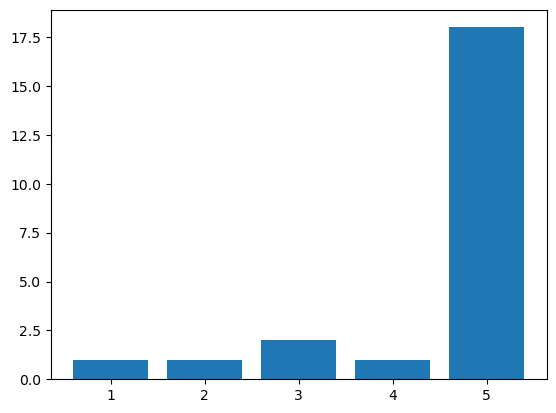

In [6]:
## YOUR SOLUTION
plt.bar(train_set[train_set['click']==1]['rating'].value_counts().index, train_set[train_set['click']==1]['rating'].value_counts().values)

In [7]:
print(train_set[train_set['click']==1]['rating'].value_counts())

rating
5    18
3     2
1     1
4     1
2     1
Name: count, dtype: Int64


Use the `rc_env.generate_evaluation_set` method with input 1000 to generate an evaluation set with 1000 samples, print the first 5 rows.


In [8]:
## YOUR SOLUTION
eval_set = rc_env.generate_evaluation_set(n_samples=1000)

Plot an histogram of true (un-noised) values. Use `df.value_counts()`.


<BarContainer object of 5 artists>

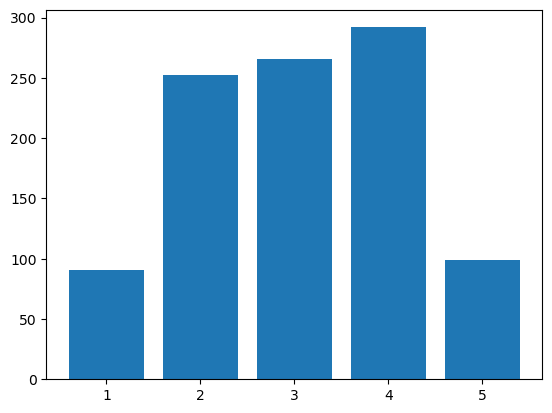

In [9]:
## YOUR SOLUTION
plt.bar(eval_set['true_relevance'].value_counts().index, eval_set['true_relevance'].value_counts().values)

How is this histogram different than the one plotted for the training set ratings? Why is that? Explain your answer.



```
Answer: The true relevance histogram shows normal distribution of the data, as opossed to the rating that shows very high bias to the rating of 5/5. We covered it in class and it may have two reasons. The first is that in ratings we get only items that passed two filters. The first filter is those items that the system deemed worthy of recommending to the user. The second filter pass only items that the user deemed interesting by clicking them.
The second reason, is what we described in class as anti buy regret. In order for the users to not regret after buying the item, they tend to exagurate its value and think of it as "the best purchase possible".
```



## 1.2 Basic model training

The utility method `rc_env.build_X_y_matrices`
extracts training matrices and labels from a given dataset DataFrame.
Entries for which the labels are missing (`N/A`) are removed from the dataset.

Arguments:
- `label_column (str)`: Name of column to be used as label (e.g 'click')
- `feature_columns (List[str])`: Columns to be used as features



Use `rc_env.build_X_y_matrices` together with previous methods to:
* Create a train set of size 1000 that includes ratings as labels.
* Train a linear regression model (use scikit-learn).
* Create an evaluation set of size 500 (that includes true relevancies $y$).
* Use the learned model to generate predicted relevancies $\hat{y}$
* Create a violin plot comparing $\hat{y}$ to $\hat{y}$ (code provided).

**Note:** You may try to re-run with different seeds.





0.3535382358455784


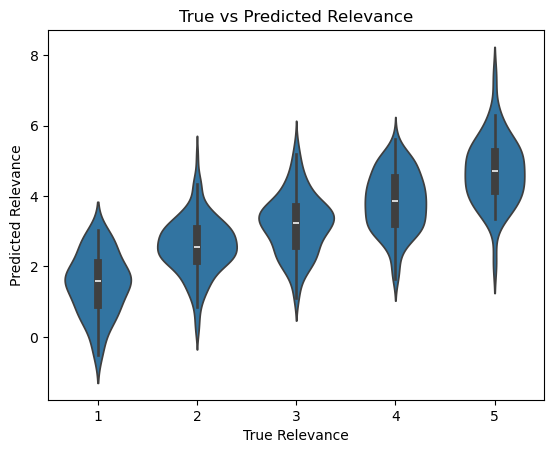

In [10]:
np.random.seed(10)
new_train_df = rc_env.generate_training_set(n_samples=1000)
new_eval_df = rc_env.generate_evaluation_set(n_samples=500)
feature_columns = [f'x{i+1}' for i in range(8)]
X, y = rc_env.build_X_y_matrices(new_train_df, 'rating', feature_columns)
LRModel = LinearRegression()
LRModel.fit(X, y)
X_test, y_test = rc_env.build_X_y_matrices(new_eval_df, 'true_relevance', feature_columns)
y_pred = LRModel.predict(X_test)
print(LRModel.score(X_test, y_test))

sns.violinplot(x=y_test, y=y_pred)
plt.xlabel('True Relevance')
plt.ylabel('Predicted Relevance')
plt.title('True vs Predicted Relevance')
plt.show()

-0.5168639984948407

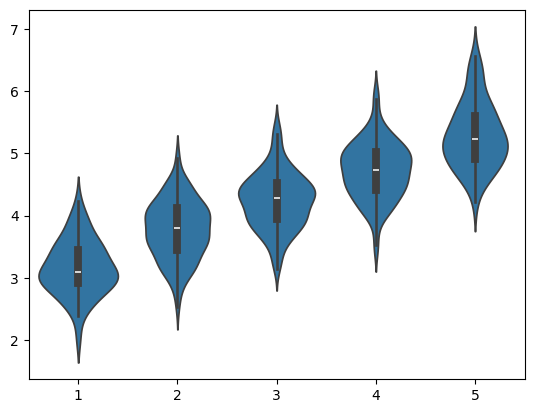

In [11]:

## YOUR SOLUTION
np.random.seed(42)
train_set = rc_env.generate_training_set(n_samples=1000)
train_set_ratings_x, train_set_ratings_y = rc_env.build_X_y_matrices(train_set, 'rating', rc_env.FEATURE_COLUMNS)
model = LinearRegression()
model.fit(train_set_ratings_x, train_set_ratings_y)
eval_set = rc_env.generate_evaluation_set(n_samples=500)
eval_set_x, eval_set_y = rc_env.build_X_y_matrices(eval_set, 'true_relevance', rc_env.FEATURE_COLUMNS)
y_predicted = model.predict(eval_set_x)
sns.violinplot(x=eval_set_y, y=y_predicted)
model.score(eval_set_x, eval_set_y)

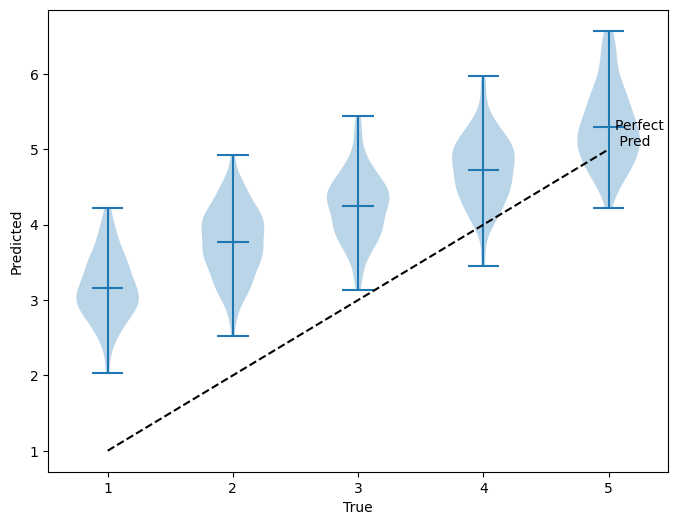

In [12]:
# [plot correlations]

# eval_r: true ratings(1d numpy.ndarray)
# pred_r: predicted ratings(1d numpy.ndarray)
eval_r = eval_set_y
pred_r = y_predicted
plt.figure(figsize=(8,6));
rs = np.sort(np.unique(eval_r))
pred_per_r = [pred_r[np.where(eval_r==r)] for r in rs]
plt.violinplot(pred_per_r, rs, showmeans=True);
plt.plot([1,5],[1,5],'k--');
plt.text(5.05, 5.05, 'Perfect \n Pred');
plt.xlabel("True");
plt.ylabel("Predicted");

**Explain the plot -** Does the linear regression model capture the true relevance?



```
Answer: It is very biased toward stating higher values than it should. This is to be expected, as we have seen and explained that the ratings are largly biased towards high score of 5/5 instead of true normal distribution. The model learned on those biased ratings and so, when tasked with prediction, it constatnly predict higher score than it should.
```



## 1.3 The effect of dataset size

* Create a `RateClickEnvironment` object with default arguments, and use it to generate an evaluation set of size 500.
* For each n in `geomspace(50,20000,8)`, generate a training dataset of size n.
* Train a click-prediction model using logistic regression.
* Train a rating-prediction model using linear regression.
* Evaluate and store the NDCG of each model on the evaluation set: use the following `rc_nev.ndcg_10` method that wraps scikit-learn's `ndcg_score` for top 10:

  * Input: 2 arrays, true relevance and predicted relevance score.
  * Output: float, score

* For each value of n, **repeat the above procedure 20 times**.
* Generate a results DataFrame with the following columns: `n_samples, repetition, click_ndcg, rating_ndcg`

Generate evaluation set (to be shared across simulation repetitions):

In [16]:
import numpy as np
import pandas as pd
np.random.seed(42)

## YOUR SOLUTION
rate_click_env = RateClickEnvironment()
eval_set = rate_click_env.generate_evaluation_set(500)
eval_set_ratings_x, eval_set_ratings_y = rate_click_env.build_X_y_matrices(eval_set, 'true_relevance', rc_env.FEATURE_COLUMNS)
train_set_sizes = np.geomspace(50, 20000, 8)

results_df = []


for train_set_size in train_set_sizes:
    for repetition in range(20):
        rounded_size = int(train_set_size)
        train_set = rate_click_env.generate_training_set(n_samples=rounded_size)
        train_set_ratings_x, train_set_ratings_y = rate_click_env.build_X_y_matrices(train_set, 'rating', rate_click_env.FEATURE_COLUMNS)
        train_set_click_x, train_set_click_y = rate_click_env.build_X_y_matrices(train_set, 'click', rate_click_env.FEATURE_COLUMNS)
        linear_model_for_rating = LinearRegression()
        logistic_model_for_click = LogisticRegression()
        linear_model_for_rating.fit(train_set_ratings_x, train_set_ratings_y)
        print(train_set_click_y[:50])      # show first 50
        print(train_set_click_y.shape)
        print(np.unique(train_set_click_y)) 
        print(train_set_click_y.dtype)
        logistic_model_for_click.fit(train_set_click_x, train_set_click_y)
        y_predicted_click = logistic_model_for_click.predict(eval_set_ratings_x)
        y_predicted_rating = linear_model_for_rating.predict(eval_set_ratings_x)
        click_ndcg = rate_click_env.ndcg_10(eval_set_ratings_y, y_predicted_click)
        rating_ndcg = rate_click_env.ndcg_10(eval_set_ratings_y, y_predicted_rating)

        new_row = {'n_samples': rounded_size, 'repetition': repetition+1, 'click_ndcg': click_ndcg, 'rating_ndcg': rating_ndcg}
        results_df.append(new_row)  

results_df = pd.DataFrame(results_df)
        


print(results_df)

[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0]
(50,)
[0 1]
object


ValueError: Unknown label type: unknown. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.

Run simulations and output results DataFrame:

In [ ]:
np.random.seed(42)
num_repeats = 20

n_values_lst = np.geomspace(50,20000,8).astype(int)

## YOUR SOLUTION


Plot a line-plot showing the average NDCG per n for each of the two models. Include error bars.

Guidance:

*   Group by trainset size
*   Calculate aggregated mean and std values for columns `click_ndcg` and `rating_ndcg`.
*   Use mean values for the series plots (the lines) and std for the error bars.

Technical tip:
*   After aggregation, your pandas DataFrame may contain multi-level columns, the methods `df.swaplevel(axis=1)` or `df.xs(...,axis=1,level=2)` may be convenient for reshaping the DataFrame before plotting.
* The pandas `plot.line` function has an optinal argument `yerr` for specfying error bar size.



In [ ]:
## YOUR SOLUTION
agg_results = results_df.groupby('n_samples').agg({'click_ndcg': ['mean', 'std'], 'rating_ndcg': ['mean', 'std']})

agg_results.columns = ['_'.join(col).strip() for col in agg_results.columns.values]

plt.figure(figsize=(10, 6))
plt.errorbar(agg_results.index, agg_results['click_ndcg_mean'], yerr=agg_results['click_ndcg_std'], label='Click NDCG', marker='o')
plt.errorbar(agg_results.index, agg_results['rating_ndcg_mean'], yerr=agg_results['rating_ndcg_std'], label='Rating NDCG', marker='o')
plt.xscale('log')
plt.xlabel('Number of Training Samples')
plt.ylabel('NDCG')
plt.title('NDCG vs Number of Training Samples')
plt.legend()
plt.grid(True)
plt.show()

**Explain the plot -** What can be observed from the graph? In What is the relation between the two lines?

```
Answer:
The Click stays mostly the same while the ratings NDCG goes up. The reason is that for the click the prediction vector we give is of binary value, because this is the prediction task. Because this is a binary, we don't give order predictions, and only the predictions of if it was clicked or no. So in the ratings, clicked will be higher than no click, but we will get a loss for not sorting between the clicked samples. This loss is garunteed, because of how NDCG averages between items that got the same ranking. This is also why we get that the STD of the click decreases as the sample size grows.
```

## 1.4 Varying click threshold
Repeat the experiment, but this time:
* Keep the number of training samples fixed at 1000.
* Vary the thershold $\mathtt{thresh\_click} \in[0,5]$. Pass this as a parameter to the `RateClickEnvironment` constructor (note this means that now the environment object should be constructed *inside* the loop).
* For every threshold parameter run 20 random repeats and average the results.

(Feel free to reuse code from the above question)

In [ ]:
click_thresholds = np.linspace(0, 5, 20)
np.random.seed(42)
## YOUR SOLUTION

results_df = []

first_zero_thresh = True



for thresh_click in click_thresholds:
    for repetition in range(20):
        rate_click_env = RateClickEnvironment(thresh_click=thresh_click)
        eval_set = rate_click_env.generate_evaluation_set(500)
        eval_set_ratings_x, eval_set_ratings_y = rate_click_env.build_X_y_matrices(eval_set, 'true_relevance', rc_env.FEATURE_COLUMNS)
        train_set = rate_click_env.generate_training_set(n_samples=1000)
        train_set_ratings_x, train_set_ratings_y = rate_click_env.build_X_y_matrices(train_set, 'rating', rate_click_env.FEATURE_COLUMNS)
        train_set_click_x, train_set_click_y = rate_click_env.build_X_y_matrices(train_set, 'click', rate_click_env.FEATURE_COLUMNS)
        if train_set_ratings_x.shape[0] == 0:
            if first_zero_thresh:
                print(f'first one- {thresh_click}')
                first_zero_thresh = False
            print("threshhold is too high - no clicks")
            y_predicted_click = np.zeros(eval_set_ratings_y.shape)
            y_predicted_rating = np.zeros(eval_set_ratings_y.shape)
        else:
            
            linear_model_for_rating = LinearRegression()
            linear_model_for_rating.fit(train_set_ratings_x, train_set_ratings_y)
            y_predicted_rating = linear_model_for_rating.predict(eval_set_ratings_x)        
            logistic_model_for_click = LogisticRegression()
            logistic_model_for_click.fit(train_set_click_x, train_set_click_y)
            y_predicted_click = logistic_model_for_click.predict(eval_set_ratings_x)
        click_ndcg = rate_click_env.ndcg_10(eval_set_ratings_y, y_predicted_click)
        rating_ndcg = rate_click_env.ndcg_10(eval_set_ratings_y, y_predicted_rating)

    new_row = {'thresh_click': thresh_click, 'repetition': repetition+1, 'click_ndcg': click_ndcg, 'rating_ndcg': rating_ndcg}
    results_df.append(new_row)  

results_df = pd.DataFrame(results_df)
        


print(results_df)

Plot Results - a line graph including clicks and ratings ndcg, similar to 1.3 but with threshold vs.ndcg. Again, feel free to reuse code.

In [ ]:
## YOUR SOLUTION
## YOUR SOLUTION

agg_results = results_df.groupby('thresh_click').agg({'click_ndcg': ['mean', 'std'], 'rating_ndcg': ['mean', 'std']})

agg_results.columns = ['_'.join(col).strip() for col in agg_results.columns.values]

plt.figure(figsize=(10, 6))
plt.errorbar(agg_results.index, agg_results['click_ndcg_mean'], yerr=agg_results['click_ndcg_std'], label='Click NDCG', marker='o')
plt.errorbar(agg_results.index, agg_results['rating_ndcg_mean'], yerr=agg_results['rating_ndcg_std'], label='Rating NDCG', marker='o')
plt.xlabel('Click Threshold')
plt.ylabel('NDCG')
plt.title('NDCG vs Click Threshold')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
results_df

**Explain the plot -** What can be observed from the graph? In What is the relation between the two lines?

```
Answer: ...
```

# Task 2: Selective rating

In real life, users rarely rate all items they consume. Moreover - both the choice of *which* items to rate, and the actual *reported* ratings, are prone to behavioral biases. In this question we will examine the effects of different reporting schemes (i.e., ways in which uesrs report or fail to report ratings, and how they modify these ratings) on learning.


We will examine five types of users:
- Rational (random): Each rating $r$ is reported with a fixed probability $p=0.4$. Note this serves as a benchmark since it does not add bias to how ratings are reported.
- Ranting: Only reports bad ratings, defined as $r \le 2$.
- Extreme: Only reports extreme ratings, defined as $r=1$ or $r=5$.
- Optimistic: Reports only if ratings are high, $r \ge 4$, but for each item with true relevance $r=4$, misreports it as $r=5$ with probability $p=0.8$.
- Overreacts: Reports ratings for items with low ratings $r \le 2$ and with high ratings $r \ge 4$, and for these, reports them with probability $p=0.5$. However, he extremifies his ratings by misreporting $r=2$ as $r=1$ and $r=4$ as $r=5$.

Note: the above criteria and probabilities ensure that for all types, ~40% of ratings are reported, so all types generate the same (expected) number of ratings.




### 2.1 Implementing user types
Implement a function `selective_ratings` that takes as input an array `r_arr` of ratings, and simulates user behavior by returning a subset of `r_arr` matching one of the above types of user reporting behaviors, as determined by the parameter `utype`. The function also takes as input the set of item features `items_train`, and returns the subset of items corresponding to the reported ratings.

You may use `rc_env._user_features` to access actual user values per features.

In [ ]:
import numpy as np
import pandas as pd
np.random.seed(42)
def selective_ratings(r_arr, utype='rational',items_train=None):
  """
  input:
  r_arr: ratings array - numpy
  utype: string

  return:
    - revealed_ratings: numpy array of revealed ratings
    - revealed_items: features of the corresponding items
  """

  if utype=='rational':

    ## YOUR SOLUTION
    r_arr_copy = r_arr.copy()
    # get the indices with probability of 0.4:
    indices = np.random.rand(len(r_arr_copy)) < 0.4
    values = r_arr_copy[indices]
    return values, items_train[indices]



  if utype=='ranting':
    ## YOUR SOLUTION
    
    indices = np.where(r_arr <= 2)[0]
    values = r_arr[indices]
    items_train = items_train[indices]
    return values, items_train

  if utype=='extreme':
    ## YOUR SOLUTION
    indices = np.where(np.logical_or(r_arr == 1, r_arr == 5))[0]
    values = r_arr[indices]
    items_train = items_train[indices]
    return values, items_train
  


  if utype=='optimistic':
    r_arr_copy = r_arr.copy()
    indices = np.where(r_arr_copy >= 4)[0]
    values = r_arr_copy[indices]
    for i in range(len(values)):
      if np.random.rand() < 0.8:
        values[i] = 5
    return values, items_train[indices]


  if utype=='overreacts':
    r_arr_copy = r_arr.copy()
    indices = np.where(r_arr_copy != 3)[0]
    random_indices = np.random.rand(len(indices)) < 0.5
    filtered_indices = indices[random_indices]
    values = r_arr_copy[filtered_indices]
    for i in range(len(values)):
      if values[i] == 4:
        values[i] = 5
      elif values[i] == 2:
        values[i] = 1
    return values, items_train[filtered_indices]
  

  if utype=='underreacts':
    r_arr_copy = r_arr.copy()
    indices = np.where(r_arr_copy != 3)[0]
    random_indices = np.random.rand(len(indices)) < 0.5
    filtered_indices = indices[random_indices]
    values = r_arr_copy[filtered_indices]
    for i in range(len(values)):
      if values[i] == 5:
        values[i] = 4
      elif values[i] == 1:
        values[i] = 2
    return values, items_train[filtered_indices]
  
  if utype=='pasimistic':
    r_arr_copy = r_arr.copy()
    indices = np.where(r_arr_copy <= 2)[0]
    values = r_arr_copy[indices]
    for i in range(len(values)):
      if np.random.rand() < 0.8:
        values[i] = 1
    return values, items_train[indices]

In [ ]:
print(selective_ratings(np.array([1,3,2,4,5,1,4]), 'pasimistic', np.array([1,2,3,4,5,6,7])))
print(selective_ratings(np.array([1,3,2,4,5,1,4]), 'overreacts', np.array([1,2,3,4,5,6,7])))

(array([1, 2, 1]), array([1, 3, 6]))
(array([1, 5, 5]), array([3, 4, 5]))


#### 2.1.1 New user types
Implement 2 data revelation models of your own, and explain the behavioral rationale behind them. Make sure that ~40% of the data is revealed. You may edit the function above.



Use next block of code to experiment with your ratings filter models

In [ ]:
"""

Try your code -
You may use ratings generated below of the evaluation..

"""

What is the rationale behind the two models? How did you make sure that ~40% of ratings are reported?
```
Answer: We have implemented a symetric user behavior on the other end of the specturm for the optimistic and the overreacts.
```

### 2.2 Training and evaluation

In this section we will:
* generates train and test data
* filter rating for each user type based on your implementation of `selective_ratings`
* Train and evaluate the performance.



2.2.1 **Before actually running the code** - give an educated guess for NDCG and RMSE values for each user type (if values are hard for you to guess, state relations, e.g. 'higher', 'lower', 'much lower'):



```
Answer: We will first simplify the intuition for NDCG so in a scenario where we have 100 values and k=10, and a ranking of the values.
CG - Get according to the rankning the top 10 items. Add the values of those items.
DCG - Get according to the rankning the top 10 items. Add the values of those item with "diminishing returns", meaning  items ranked lower will have lower impact on the gain value.
NDCG - To prevent the values from "exploding, normilize it by the max value possible, which is an accurate ranking of the values.
Also, to simplify the intuitive approach, we will think about which items our ranking with a given user type completly eliminates from being chosen, and which it keeps in the pool of "possible k items" that it would also rank in.
RMSE - In contrast, the RMSE cares less about ranking the items, and more about the bias of the model.
To sum it up, RMSE cares more about bias, while NDCG more about variance (in regard to the top items predictions)

So in NDCG the predicted order is:
Rational
Extreme
Overreacts/underreact
ranting
optimistic/pasimistic.
Explanation: Rational gives us the best results because it conveys the real values.
We then have extreme, which makes a model trained on them think in a binary mindset, resulting in linear regression that operates as a logical regression. It will probably be good at identifying the top items for this reason.
Overreacts/Underreacts - those are symetric, both give us kind of the binary split as the explanation but they add a chance to misreport the label, causing the model to not figure out the best possible features that distinguish the 4s and the 5s.
Ranting - It will create a big bias towards the low results, and so it will be hard for the model to find and learn the good features. But at least it doesn't mislead in the labels reported.
Potimistic/Pasimistic - both show only one end of the spectrum and also have high precentage of misleading.



RMSE:
Rational
Underreacts
Extreme/Overreacts
Ranting
optimistic/pasimistic

```



2.2.2 Generate traning set of size 5000 and evaluation set of size 1000. Use `build_X_y_matrices` to get `rating` as label for training and `true_relevance` for the evaluation.

In [ ]:
np.random.seed(42)

## YOUR SOLUTION
rc_env = RateClickEnvironment()
new_train_df = rc_env.generate_training_set(n_samples=5000)
new_eval_df = rc_env.generate_evaluation_set(n_samples=1000)
train_set_ratings_x, train_set_ratings_y = rc_env.build_X_y_matrices(new_train_df, 'rating', rc_env.FEATURE_COLUMNS)
eval_set_ratings_x, eval_set_ratings_y = rc_env.build_X_y_matrices(new_eval_df, 'true_relevance', rc_env.FEATURE_COLUMNS)

For each user type train and evaluate the results. Print ndcg and rmse.

In [ ]:

utypes = ['rational', 'ranting', 'extreme', 'optimistic', 'overreacts', 'underreacts','pasimistic' ] #todo: add your own

ndcgs = []
rmses = []
preds = []

for utype in utypes:

  ## YOUR SOLUTION
  model = LinearRegression()
  user_train_y, user_train_x = selective_ratings(train_set_ratings_y, utype, train_set_ratings_x)
  model.fit(user_train_x, user_train_y)
  y_predicted = model.predict(eval_set_ratings_x)
  preds.append((utype,y_predicted))
  ndcg = rc_env.ndcg_10(eval_set_ratings_y, y_predicted)
  rmse = mean_squared_error(eval_set_ratings_y, y_predicted, squared=False)
  rmses.append((utype, rmse))
  ndcgs.append((utype, ndcg))

print('the ndcgs are:')
print(ndcgs)
print('the rmses are:')
print(rmses)

print('ndcgs sorted:')
print(sorted(ndcgs, key=lambda x: x[1], reverse=True))
print('rmses sorted:')
print(sorted(rmses, key=lambda x: x[1], reverse=False))

the ndcgs are:
[('rational', 0.9740249976693319), ('ranting', 0.6187629318641255), ('extreme', 0.9872758423602097), ('optimistic', 0.5421876289638841), ('overreacts', 0.9304217147628471), ('underreacts', 1.0), ('pasimistic', 0.749060324883579)]
the rmses are:
[('rational', 1.0674274114083682), ('ranting', 1.6244550720118534), ('extreme', 1.425822072522502), ('optimistic', 2.183742943469205), ('overreacts', 1.6249532509788347), ('underreacts', 0.9518409767771551), ('pasimistic', 2.149843906790184)]
ndcgs sorted:
[('underreacts', 1.0), ('extreme', 0.9872758423602097), ('rational', 0.9740249976693319), ('overreacts', 0.9304217147628471), ('pasimistic', 0.749060324883579), ('ranting', 0.6187629318641255), ('optimistic', 0.5421876289638841)]
rmses sorted:
[('underreacts', 0.9518409767771551), ('rational', 1.0674274114083682), ('extreme', 1.425822072522502), ('ranting', 1.6244550720118534), ('overreacts', 1.6249532509788347), ('pasimistic', 2.149843906790184), ('optimistic', 2.18374294346920

## 2.3 Reflection
#### Comparing guesses and results
Do these results match your guesses? Why, or why not?


To answer fully run the following cell first.
It will generate a violin plots of per user type.

Use these distributions to explain ndcg and rmse preformance.

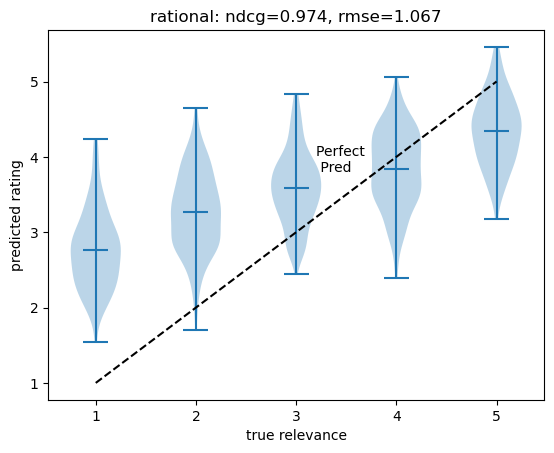

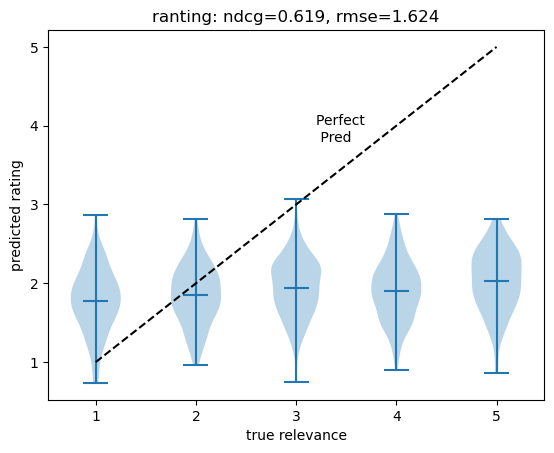

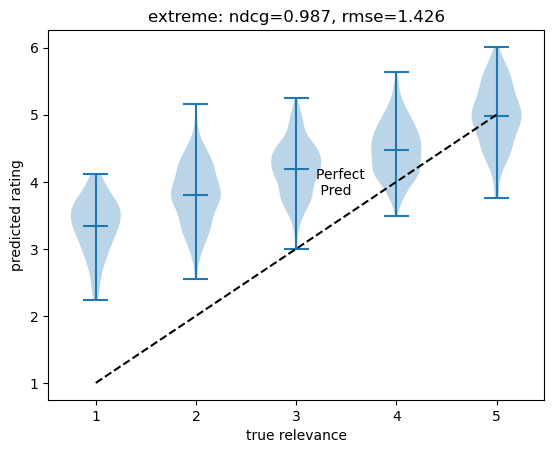

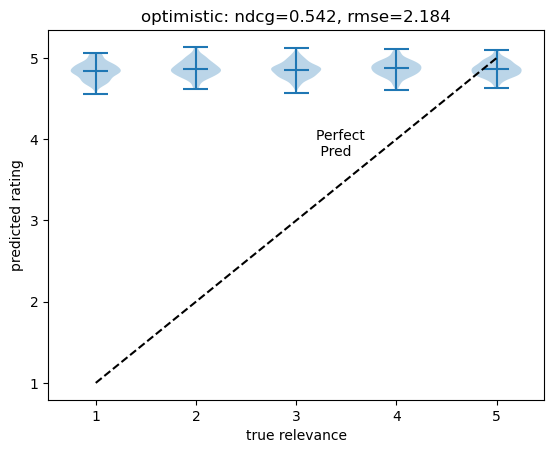

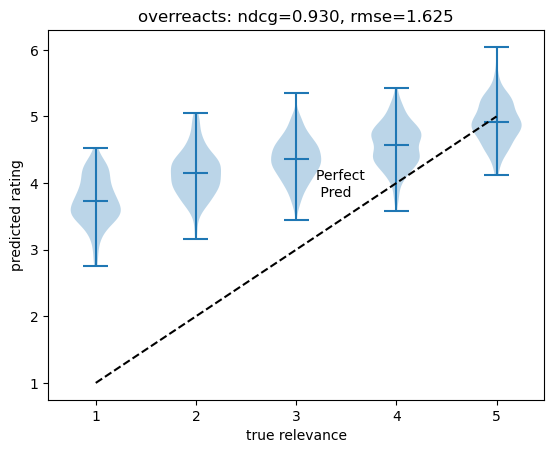

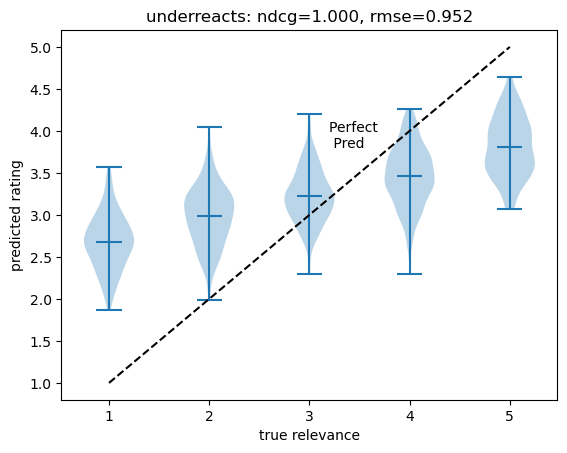

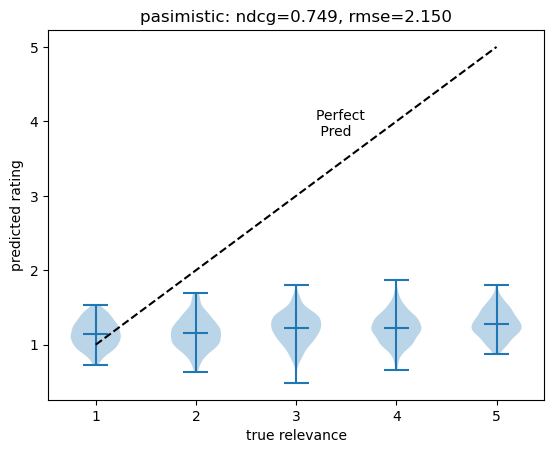

In [ ]:
preds = [t[1] for t in preds]
ndcgs = [t[1] for t in ndcgs]
rmses = [t[1] for t in rmses]
true_relevance = eval_set_ratings_y
for utype_, pred_, ndcg_, rmse_ in zip(utypes, preds, ndcgs, rmses):
  rs = np.sort(np.unique(true_relevance))
  pred_per_r = [pred_[np.where(true_relevance==r)] for r in rs]
  plt.violinplot(pred_per_r, rs, showmeans=True)
  plt.plot([1,5],[1,5],'k--');
  plt.xlabel('true relevance')
  plt.ylabel('predicted rating')
  plt.title('{}: ndcg={:.3f}, rmse={:.3f}'.format(utype_, ndcg_, rmse_))
  plt.text(3.2, 3.8, 'Perfect \n Pred');
  plt.show()

Explain the results:



```
Answer:

So in NDCG the predicted order is:
Rational
Extreme
Overreacts/underreact
ranting
optimistic/pasimistic.

The real order is:
[('rational', 1.0), ('extreme', 0.9872758423602097), ('overreacts', 0.9829713764716758), ('underreacts', 0.9590331504962818), ('pasimistic', 0.8580684430284474), ('optimistic', 0.7101381097598957), ('ranting', 0.6187629318641255)]

We were very close! we only got the ranting wrong, we thought it will be better than the optimistic passimistic but we didn't guess correctly. It might be only do to the fact that a lot of probability is involved in the passimistic and optimistic. Or maybe it is the fact that when learning on an already biased data, in ndcg it is better to just categorize all the wanted features as "good" and not try to destinguish between them.


RMSE Predicted:
Rational
Underreacts
Extreme/Overreacts
Ranting
optimistic/pasimistic

The real rmses sorted:
[('rational', 0.7352830546896663), ('overreacts', 0.8730232907270585), ('underreacts', 1.125789789190308), ('extreme', 1.425822072522502), ('ranting', 1.6244550720118534), ('optimistic', 2.1988668574652444), ('pasimistic', 2.3941287581135646)]

We only got it wrong with the overreacts and underreacts (we should have switched them), it can also be that when showing this biased data to the model, we should have better destingshion.
```



## 2.4 Sub Populations and IPW

In this segment, our dataset encompasses two distinct user groups: *Ranters*, which like to complain and *Extreme Rankers* which report extreme enjoyment or disappointment. These groups vary not only in their rating policies but also in user features. Your objective with this imbalanced training set is to learn "true_relevance" based on rated items.

To improve the baseline performance, you'll explore using inverse propensity weighting (IPW). In practical scenarios, you might not know the user type during testing. Propensity weighting can help account for this uncertainty and capture the information effectively.


The function `generate_population` generates train and test dataframes which include items' feature columns and either received `rating` or `true_relevance`. In addition, each dataset has a `user_type` column. A binary column which indicates if the item displayed was rated by a *Ranter* or not.
You may **not** use this column directly in your training process.






In [192]:
np.random.seed(12)

train_df, test_df = generate_population()

## YOUR SOLUTION
train_df_copy = train_df.copy()
test_df_copy = test_df.copy()

In [193]:
test_df.head()

,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,true_relevance,user_type
0,0.103400,0.979962,0.479258,0.243398,0.223927,-0.964782,0.612778,-1.009753,3.0,1.0
1,0.072498,-1.485999,1.162558,0.686731,1.274385,-0.751220,0.203763,-0.170743,3.0,1.0
2,0.342240,1.340756,-0.758132,-0.218038,1.286706,0.253717,1.346264,-0.189104,4.0,1.0
3,-0.464832,-0.171085,-0.114663,-0.728297,-0.110148,0.682070,-0.558851,0.106233,2.0,1.0
4,0.700510,-0.722941,1.087256,1.013562,0.602366,-0.576109,-0.625558,0.702659,4.0,1.0


As discussed in the lecture, leverage `LogisticRegression` to calculate propensity weights for each item. Using `user_type` is allowed for weights calculation.

Note that`LogisticRegression`default settings includes regularization.

In [194]:
import pandas as pd

## YOUR SOLUTION
# Create a new column 'label' in train_df and test_df
train_df['label'] = 1
test_df['label'] = 0

# Align the columns of train_df and test_df, so rename the 'true_relevance' column to 'rating'
test_df.rename(columns={'true_relevance': 'rating'}, inplace=True)


# Concatenate train_df and test_df
new_df = pd.concat([train_df, test_df])

# Reset the index of the new_df
new_df.reset_index(inplace=True)

# Print the new_df
print(new_df)

      index       x_0       x_1       x_2       x_3       x_4       x_5  \
0         0 -0.806982  0.305326  0.555582  1.404252 -1.442838 -0.587031   
1         1  1.095956 -0.409981  1.154018  1.182049  1.153588 -0.661879   
2         2  0.640761  1.554899  1.091573  0.262525   1.94396  2.299703   
3         3 -0.039209  0.063409 -0.351597   0.27653  2.055129 -1.091365   
4         4  0.073252  0.711241   0.35523  0.146947 -1.124392  0.204625   
...     ...       ...       ...       ...       ...       ...       ...   
2511    495  0.557443 -0.006507 -0.498646  0.241122  1.038622  0.986138   
2512    496 -1.268128 -0.461892  0.970221   1.24247  0.725432  0.067837   
2513    497 -0.084638  0.296402 -0.023239 -0.969836  -0.34386  1.339715   
2514    498 -1.406322 -0.946509 -1.908647  0.292162 -1.470767  0.187108   
2515    499 -0.246658  1.131945  0.240462 -0.306592 -1.605988  1.987788   

           x_6       x_7 rating  user_type  label  
0    -0.085144 -1.455655      2        1.0     

In [195]:
# Train a logistic regression model on the new_df to find the weights for the IPW
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
label_column = 'label'
feature_columns = [col for col in new_df.columns if col != 'label']
model.fit(new_df[feature_columns], new_df[label_column])

# Calculate the IPW weights
eps = 1e-6
new_df['weights'] = np.clip(model.predict_proba(new_df[feature_columns])[:, 1], eps, 1 - eps) / np.clip(model.predict_proba(new_df[feature_columns])[:, 0], eps, 1 - eps) 

/Users/arielshalem/miniconda3/envs/cs236781-hw2/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [196]:
print(new_df.head(n=10))

   index       x_0       x_1       x_2       x_3       x_4       x_5  \
0      0 -0.806982  0.305326  0.555582  1.404252 -1.442838 -0.587031   
1      1  1.095956 -0.409981  1.154018  1.182049  1.153588 -0.661879   
2      2  0.640761  1.554899  1.091573  0.262525   1.94396  2.299703   
3      3 -0.039209  0.063409 -0.351597   0.27653  2.055129 -1.091365   
4      4  0.073252  0.711241   0.35523  0.146947 -1.124392  0.204625   
5      5  1.636463 -1.034741  0.498443  1.978233  0.427943 -0.915226   
6      6 -1.259224 -0.923445  1.255034  0.525156 -0.334466  0.843229   
7      7 -0.969176 -0.826602  0.592006  0.939068  1.093105  -0.64074   
8      8  1.689292 -0.274805  0.608088  0.312588   1.15852  -0.18287   
9      9 -1.120041  0.953378  -0.01803   1.49915   1.68333  -0.45079   

        x_6       x_7 rating  user_type  label     weights  
0 -0.085144 -1.455655      2        1.0      1    0.629839  
1 -2.443089  0.471663      1        1.0      1   33.641296  
2  -1.67621 -0.324599   

Use `RandomForestRegressor` model to fit to ratings and predict true relevance.
Calculate baseline preformance and weighted preformance.

Save overall test NDCG, and for each the sub population (e.g NDCG for *Ranters*).


In [197]:
## YOUR SOLUTION
forest_model = RandomForestRegressor()
feature_columns = [f'x_{i}' for i in range(8)]

forest_model.fit(train_df_copy[feature_columns], train_df_copy['rating'], sample_weight=new_df.loc[train_df_copy.index, 'weights'])

ndcgs = {}

In [198]:
# Calculate the NDCG score of the forest_model on the test_df
X_test = test_df_copy[feature_columns]
y_test = test_df_copy['true_relevance']
y_pred = forest_model.predict(X_test)
ndcg = rc_env.ndcg_10(y_test, y_pred)
print(ndcg)
ndcgs['all_weighted'] = ndcg

# now show for forest model without weights
forest_model = RandomForestRegressor()
forest_model.fit(train_df_copy[feature_columns], train_df_copy['rating'])
y_pred = forest_model.predict(X_test)
ndcg = rc_env.ndcg_10(y_test, y_pred)
print(ndcg)
ndcgs['all_non_weighted'] = ndcg


1.0
0.9480499953386636


In [199]:
# Compare the NDCG scores of the forest_model with and without weights only for the ranting users
# Select the ranting users from the test_df
ranting_users = train_df_copy[train_df_copy['user_type'] == 1]
forest_model = RandomForestRegressor()
forest_model.fit(ranting_users[feature_columns], ranting_users['rating'], sample_weight=new_df.loc[ranting_users.index, 'weights'])
ranting_users_test = test_df_copy[test_df['user_type'] == 1]
y_pred = forest_model.predict(ranting_users_test[feature_columns])
ndcg = rc_env.ndcg_10(ranting_users_test['true_relevance'], y_pred)
print(ndcg)
ndcgs['ranting_weighted'] = ndcg


forest_model = RandomForestRegressor()
forest_model.fit(ranting_users[feature_columns], ranting_users['rating'])
y_pred = forest_model.predict(ranting_users_test[feature_columns])
ndcg = rc_env.ndcg_10(ranting_users_test['true_relevance'], y_pred)
print(ndcg)
ndcgs['ranting_non_weighted'] = ndcg



0.917717410637865
0.7999999999999999


In [200]:
# Compare the NDCG scores of the forest_model with and without weights only for the extreme users
# Select the ranting users from the test_df
extreme_users = train_df_copy[train_df_copy['user_type'] == 1]
forest_model = RandomForestRegressor()
forest_model.fit(extreme_users[feature_columns], extreme_users['rating'], sample_weight=new_df.loc[extreme_users.index, 'weights'])
extreme_users_test = test_df_copy[test_df['user_type'] == 1]
y_pred = forest_model.predict(extreme_users_test[feature_columns])
ndcg = rc_env.ndcg_10(extreme_users_test['true_relevance'], y_pred)
print(ndcg)
ndcgs['extreme_weighted'] = ndcg


forest_model = RandomForestRegressor()
forest_model.fit(extreme_users[feature_columns], extreme_users['rating'])
y_pred = forest_model.predict(extreme_users_test[feature_columns])
ndcg = rc_env.ndcg_10(extreme_users_test['true_relevance'], y_pred)
print(ndcg)
ndcgs['extreme_non_weighted'] = ndcg



0.7150552925097237
0.7735773713303784


Use a bar graph to plot results in trems of NDCG. Use to series, to represent weighted and un-weighted preformace for each population (Ranters, Extreme reporters and overall).

Note: changes in preformance don't have to be major.

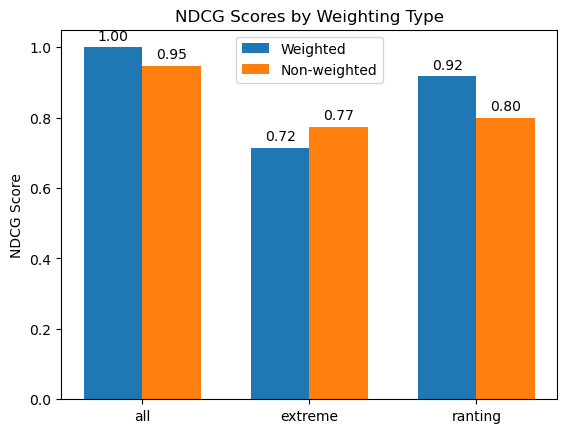

In [201]:
## YOUR SOLUTION
import matplotlib.pyplot as plt

# Extract the relevant values from the ndcgs dictionary
labels = ['all', 'extreme', 'ranting']
weighted_values = [ndcgs[f'{label}_weighted'] for label in labels]
non_weighted_values = [ndcgs[f'{label}_non_weighted'] for label in labels]

# Plot the bar chart
x = range(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x, weighted_values, width, label='Weighted')
rects2 = ax.bar([i + width for i in x], non_weighted_values, width, label='Non-weighted')

# Add labels, title, and legend
ax.set_ylabel('NDCG Score')
ax.set_title('NDCG Scores by Weighting Type')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(labels)
ax.legend()

# Add value labels to the bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}', xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')
        
autolabel(rects1)
autolabel(rects2)

plt.show()

**Explain the results:**



```
Answer:...
```



**Explain:** Why would IPW be a viable strategy in this secenario?

```
Answer:...
```